## Importing Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


import os
import time
from datetime import datetime 
import os
import copy
import tqdm

## Setting default paths

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 64
num_classes = 3
inputs_size = 224

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# data paths
train_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_train.csv'
val_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_val.csv'
test_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_test.csv'

inference_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_test.csv'
inference_model_path = '/content/drive/MyDrive/final year project/models/vgg19/run6/run6/best_model_vgg19.pt'

# root path
root_dir = '/content/drive/MyDrive/final year project/datasets/skin_mnist'

## Custom Pytorch Dataset


In [12]:
# custom pytorch dataset for the SkinMnistDataset 
class SkinMnistDataset(Dataset):
  '''
  csv_file is the csv_file containing the information
  root_dir is the parent directory/folder containing the images
  transforms specifies the transformation to be applied on the images
  '''

  def __init__(self, csv_file, root_dir, transforms=None):
    self.csv_file = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transforms = transforms

  def __len__(self):
    '''
    :return: returns the length of the dataset
    '''
    return len(self.csv_file)
  
  def __getitem__(self, item):
    """
    :param item:it is the the index of the data item to be fetched.
    :return: it returns the specified index dataitem and its corresponding label
    """
    image_path = os.path.join(self.root_dir, self.csv_file['image_path'][item])
    image = Image.open(image_path)
    row = self.csv_file.iloc[item, -3:]
    label = torch.tensor(row)

    if self.transforms:
      image=self.transforms(image)
    return (image, label)


In [13]:
#image transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.6373545 , 0.44605875, 0.46191868],[0.27236816, 0.22500427, 0.24329403])
    ]),
    'test': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.6373545 , 0.44605875, 0.46191868], [0.27236816, 0.22500427, 0.24329403])
    ]),
}

# Loading the model



In [14]:
class Hook():
    def __init__(self, module):
        self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [15]:
# Loading the inference model
model_ft = models.vgg19_bn()
hook = Hook(model_ft.features[50])

# Making the changes done on model during training
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

# loading inference state dictionary
model_ft.load_state_dict(torch.load(inference_model_path))

# setting on evaluation mode
model_ft.eval()

# create the criterion, dataset and dataloaders 
criterion = nn.CrossEntropyLoss()
inference_dataset = SkinMnistDataset(inference_csv_file, root_dir,data_transforms['test'])
dataloader = {'inference':DataLoader(dataset=inference_dataset, batch_size=batch_size)}



for i,(name,parameter) in enumerate(model_ft.named_parameters()):
    
    print(i,name)
model_ft.parameters

0 features.0.weight
1 features.0.bias
2 features.1.weight
3 features.1.bias
4 features.3.weight
5 features.3.bias
6 features.4.weight
7 features.4.bias
8 features.7.weight
9 features.7.bias
10 features.8.weight
11 features.8.bias
12 features.10.weight
13 features.10.bias
14 features.11.weight
15 features.11.bias
16 features.14.weight
17 features.14.bias
18 features.15.weight
19 features.15.bias
20 features.17.weight
21 features.17.bias
22 features.18.weight
23 features.18.bias
24 features.20.weight
25 features.20.bias
26 features.21.weight
27 features.21.bias
28 features.23.weight
29 features.23.bias
30 features.24.weight
31 features.24.bias
32 features.27.weight
33 features.27.bias
34 features.28.weight
35 features.28.bias
36 features.30.weight
37 features.30.bias
38 features.31.weight
39 features.31.bias
40 features.33.weight
41 features.33.bias
42 features.34.weight
43 features.34.bias
44 features.36.weight
45 features.36.bias
46 features.37.weight
47 features.37.bias
48 features.40

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Inference 

In [16]:
def inference(dataloaders, criterion):

    running_loss = 0.0
    running_corrects = 0
    preds=[]
    for inputs, labels in dataloaders['inference']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = torch.max(labels, 1)[1]
     
        outputs = model_ft(inputs)
        pred = torch.max(outputs, 1)[1]
        preds.append(pred)
        loss = criterion(outputs, labels)

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)
        
    test_loss = running_loss / len(dataloaders['inference'].dataset)
    test_acc = running_corrects.double() / len(inference_dataset)

    print('Inference Results:\n Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))
    return preds, test_loss, test_acc 

In [17]:
preds, loss, acc = inference(dataloader,criterion)
preds

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Inference Results:
 Loss: 0.3511 Acc: 0.9000


[tensor([1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 1, 1, 0,
         0, 2, 2, 1, 2, 0, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0], device='cuda:0')]

# Image plotting function

In [18]:
def imshow(inp, title=None,alpha=1,map=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6373545 , 0.44605875, 0.46191868])
    std = np.array([0.27236816, 0.22500427, 0.24329403])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(1,2,1)
    plt.imshow(inp)
    if map is not None:
        plt.imshow(map,cmap='jet',alpha=alpha)
        plt.subplot(1,2,2)
        plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)  # pause a bit so that plots are updated



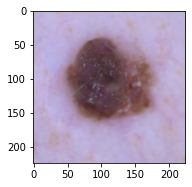

In [19]:
imshow(inference_dataset[2][0])

# Gradcam


In [20]:
inference_dataset[2][0].unsqueeze(0).shape
for batch_x,_ in dataloader['inference']:
    print(batch_x.size())
    break

torch.Size([40, 3, 224, 224])


In [21]:
with torch.enable_grad():
    pred = torch.max(model_ft(inference_dataset[2][0].unsqueeze(0).to(device)))

model_ft.zero_grad()
pred.backward()


In [22]:
act_grad=hook.input[0]
act_grad2=hook.output[0]

In [23]:
hook.input[0].shape,hook.output[0].shape

(torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]))

In [24]:
avg_pool=torch.nn.functional.avg_pool2d(act_grad,14)
map=torch.zeros(14,14).to(device)
for i in range(0,512):
    map = map + (avg_pool[0][i].item()*act_grad[0][i])
map = torch.nn.functional.relu(map)

In [25]:
avg_pool2=torch.nn.functional.avg_pool2d(act_grad2,14)
map2=torch.zeros(14,14).to(device)
for i in range(0,512):
    map2 = map2 + (avg_pool2[0][i].item()*act_grad2[0][i])
map2 = torch.nn.functional.relu(map2)

In [26]:
act_grad.squeeze().shape[0],avg_pool.squeeze().unsqueeze(0).shape[1]

(512, 512)

In [27]:
(map.cpu()==map2.cpu()).sum()

tensor(2)

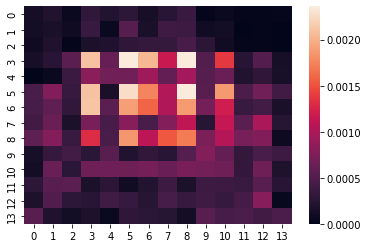

In [28]:
from seaborn import  heatmap
heatmap(map.cpu())


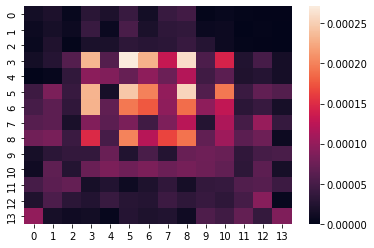

In [29]:
heatmap(map2.cpu())

In [30]:
map_2=zoom(map2.cpu(), (16,16), order=1)
map_1=zoom(map.cpu(), (32,32), order=1)

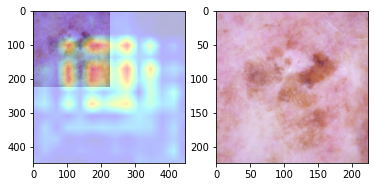

In [31]:
imshow(inference_dataset[3][0],alpha=0.3,map=map_1)


In [32]:
import torch
import torch.nn as nn
from seaborn import  heatmap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Hook():
    def __init__(self, module):
        self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

def gradcam(model, image, hook_layer=None):
    """ 
    Gradcam visualiztion of the image using the given model.

    Arguments:
    model       :   vgg 19 model to be used for inference and calculating gradients of activations
    image       :   image to visualize gradcam for
    hook_layer  :   layer of the model whose activations are to be used for calculating gradients

    """

    # hooking 
    if hook_layer is None:
        hook_layer = model.features[49]
    hook = Hook(hook_layer)
    
    # inference and gradient calculation
    model.eval()
    with torch.enable_grad():
        pred = torch.max(model(image.unsqueeze(0).to(device)))
    model.zero_grad()
    pred.backward()

    # ReLU of the avg-pooled linear combination of the channels  
    act_grad=hook.output[0]
    avg_pool=nn.functional.avg_pool2d(act_grad,14)
    map=torch.zeros(14,14).to(device)
    for i in range(0,512):
        map = map + (avg_pool[0][i].item()*act_grad[0][i])
    map = nn.functional.relu(map)
    map=zoom(map.cpu(), (32,32), order=0)
    # plotting heatmap
    imshow(image,alpha=0.3,map=map_1)

    return map

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


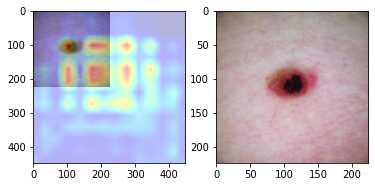

In [33]:
map=gradcam(model_ft, inference_dataset[29][0])

In [34]:


def mshow(inp,map, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6373545 , 0.44605875, 0.46191868])
    std = np.array([0.27236816, 0.22500427, 0.24329403])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
    plt.imshow(map,cmap='hot',alpha=0.1)
    plt.show()
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

In [35]:
mshow(inference_dataset[2][0])

TypeError: ignored

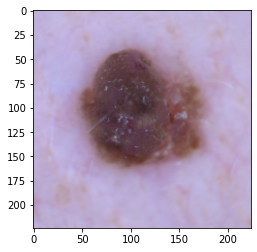

In [36]:
inp=inference_dataset[2][0].numpy().transpose((1, 2, 0))
mean = np.array([0.6373545 , 0.44605875, 0.46191868])
std = np.array([0.27236816, 0.22500427, 0.24329403])
inp = std * inp + mean
# inp = np.clip(inp, 0, 1)
plt.imshow(inp,alpha=1.2)
# plt.imshow(map,alpha=0.2)
plt.show()